# Purpose of this simulation


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
import numpy as np
import aopy
import sklearn
from weights import *

# so that we write in latex
from matplotlib import rc

# rc('font', **{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('talk')

/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:8: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:8: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# ideas

In [4]:


data_dump_folder = \
'/home/aolab/sijia/data/figure2_simulation_setup/'

ROUND_DECIMALS = 3


random_seed = 0
n_neurons = 128
s = 1.0

# clda setup 
rho = 0.5
batch_len = 100
feature_selection_method = "full"
encoder_change_mode = "same"
# encoder_change_mode = "change_to_zeros"

noises = [32]
fixed_noise_level = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3

norm_var_2 = [mean_first_peak, mean_second_peak]
mean_second_peaks = [50, 110]

# feature_selection_method 
FEATURE_SELECTOR_TYPE = "full"
exp_conds = []


exp_conds = [f'{FEATURE_SELECTOR_TYPE}_{s}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_{encoder_change_mode}'\
            for mean_second_peak in mean_second_peaks]

print(data_dump_folder)
print(exp_conds)

/home/aolab/sijia/data/figure2_simulation_setup/
['full_1.0_0_noise_32_128_50_3_clda_rho_0.5_batchlen_100_same', 'full_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_same']


In [5]:
from afs_files import load_feature_selection_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 2 number of experiments


In [10]:
feature_weights_all = [exp_data_all[i]['feature_selection']['feature_weights'] for i in range(len(exp_data_all))]

len(feature_weights_all)


2

In [12]:
# plot the histogram of the feature weights

colors = ['b', 'orange']

fig_weight, ax_weight = plt.subplots()

std = 3

bins = np.linspace(0, 150, 50)

for feature_weights, c in zip(feature_weights_all, colors):

    ax_weight.hist(feature_weights, bins, color = c, label = f'{std} Hz', alpha = 0.5 )
    ax_weight.axvline(x = 75, color = 'k')
    ax_weight.set_xlabel('Modulation depth (Hz)')
    ax_weight.set_ylabel('Counts')
    ax_weight.set_title(f'Feature distribution std {std} Hz')
    
fig_weight.show()

# Check feature selection strategies

## Plot selected features across feature selection methods

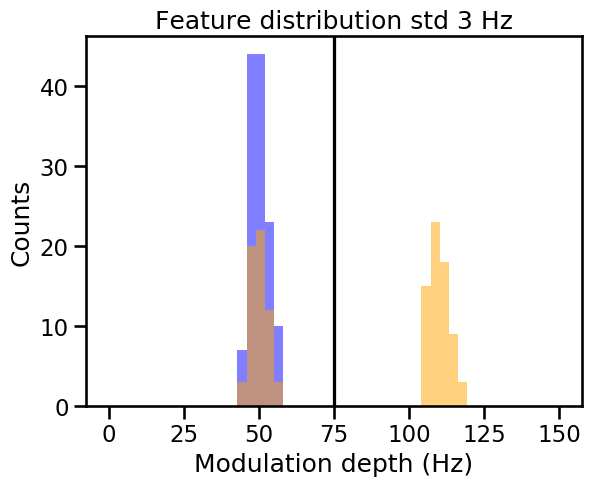

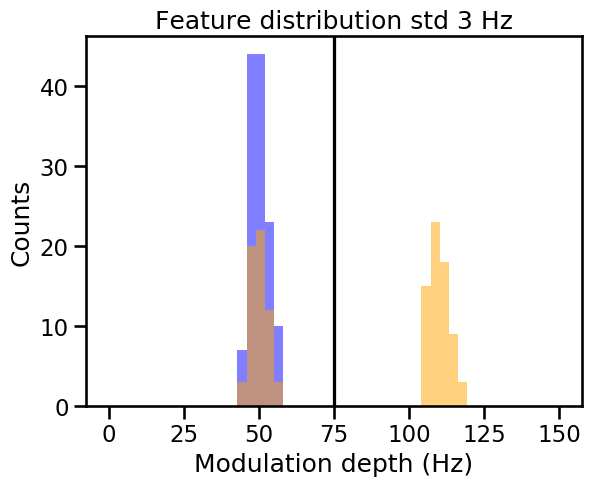

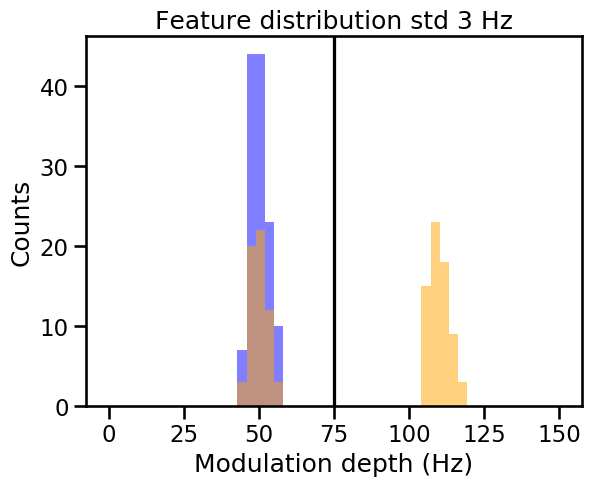

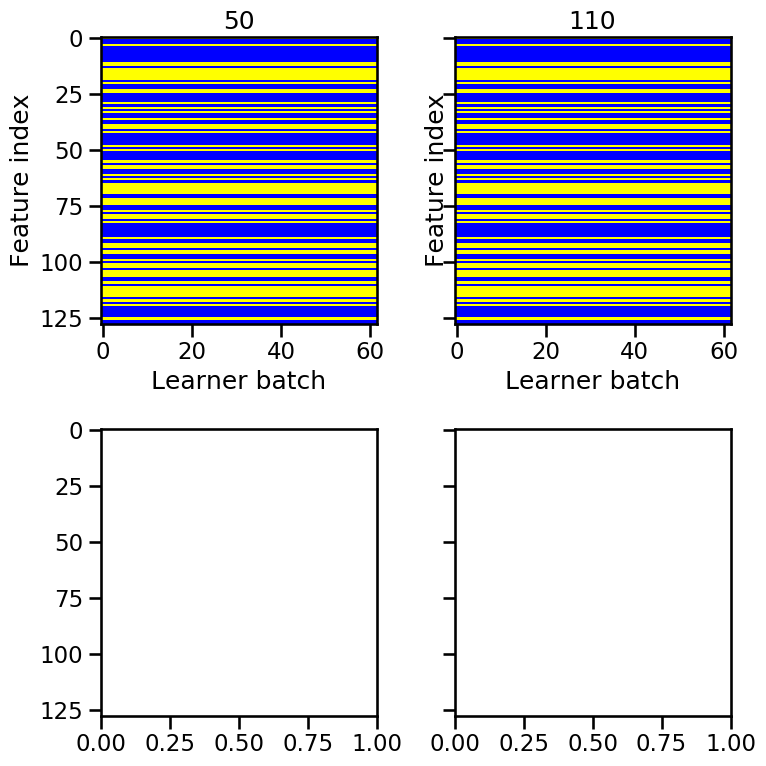

In [11]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 2, 
                                                    sharey = True,
                                                    figsize = (8, 8))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(mean_second_peaks[i] )

    fig_feat_activity.tight_layout()

plt.show()

In [13]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

selected_feature_batches = [exp_data_all[i]['feature_selection']['feat_set'] for i in range(len(exp_data_all))]

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())

num_features_exp_by_batch = np.array(num_features_exp_by_batch)
selected_feature_batches = np.array(selected_feature_batches)

In [14]:
print(selected_feature_batches.shape)

selected_features_conds_by_feature_batches = np.moveaxis(selected_feature_batches, 1, 2)


smoothness_conds_by_batch = \
calculate_feature_smoothness_multiple_conditions(selected_features_conds_by_feature_batches, 
                                                 mode = "incremental")

print(smoothness_conds_by_batch.shape)

(2, 62, 128)
(2, 61)



# Behaviour comparision

## count how many rewards

In [15]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    
    
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)
    
    # print(num_rewards, reward_rate, window_time_stamps)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)



In [16]:
colors = ['blue', 'orange', 'red']

plt.plot( window_time_stamps, reward_rate_all.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')




Text(0, 0.5, 'Reward rate (rewards/min)')

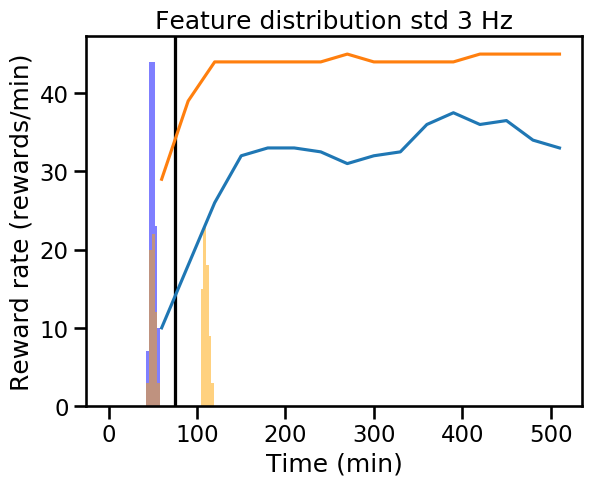

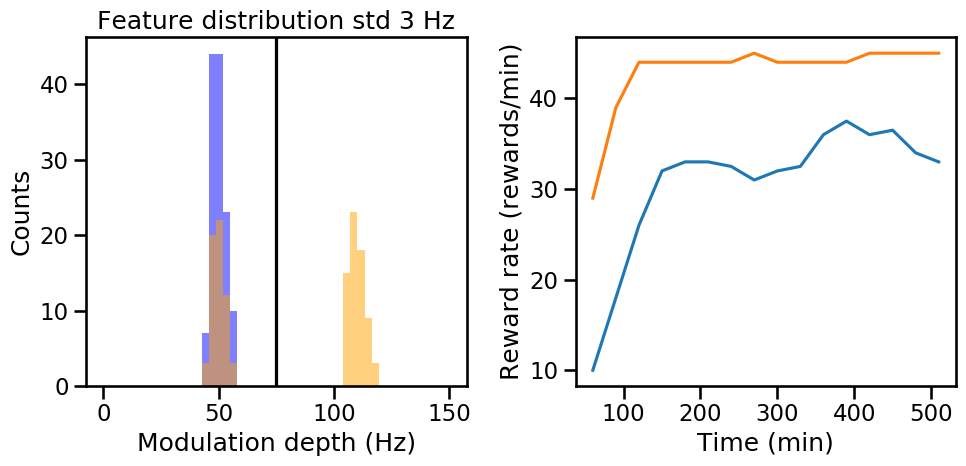

In [17]:
colors = ['b', 'orange']
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
std = 3
bins = np.linspace(0, 150, 50)
for feature_weights, c in zip(feature_weights_all, colors):
    axs[0].hist(feature_weights, bins, color=c, label=f'{std} Hz', alpha=0.5)
    axs[0].axvline(x=75, color='k')
    axs[0].set_xlabel('Modulation depth (Hz)')
    axs[0].set_ylabel('Counts')
    axs[0].set_title(f'Feature distribution std {std} Hz')

# Second subplot
axs[1].plot(window_time_stamps, reward_rate_all.T )
axs[1].set_xlabel('Time (min)')
axs[1].set_ylabel('Reward rate (rewards/min)')

plt.tight_layout()
plt.show()


In [15]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

import functools

def get_all_cursor_trajectories(exp_data_all, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    cursor_trajectories_list = list()
        
    for e in exp_data_all:
        (cursor_trajectories, trial_segments, trial_times) = get_cursor_trajectories_from_parsed_data(e, start_code = start_code, end_codes=end_codes)
        cursor_trajectories_list.append(cursor_trajectories)

    
    return cursor_trajectories_list

def get_cursor_trajectories_from_parsed_data(exp_data, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    
    events = exp_data['events']
    cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle

    streamed_code = events['code']
    event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

    trial_segments, trial_times = aopy.preproc.get_trial_segments(streamed_code, event_cycles, start_code,  end_codes)
    trial_segments = np.array(trial_segments)
    trial_indices = [range(t[0], t[1]) for t in trial_times]
    cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
    
    return (cursor_trajectories, trial_segments, trial_times)

In [20]:
start_codes = range(17, 24)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)


range(17, 24)


In [17]:
def calc_trial_times(trial_times):
    """
    for each row, calculate the difference between the last and first elements
    """
    row_index = 1 
    
    return np.apply_along_axis(lambda row: row[-1] - row[0], row_index, trial_times)


#calc_trial_times(trial_times)

In [18]:
# get the unique target positions

from typing import List, Dict
import seaborn as sns


def plot_cursor_trajectories(cursor_trajectories: List, exp_data:Dict, exp_metadata,ax = None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)


    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    
    sns.color_palette("dark:salmon_r", as_cmap=True)

    aopy.visualization.plot_trajectories(cursor_trajectories, bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, ax = ax)

# Analyze the encoder shuffle result

In [29]:


data_dump_folder = \
'/home/aolab/sijia/data/figure2_simulation_setup/'

ROUND_DECIMALS = 3


random_seed = 0
n_neurons = 128
s = 1.0

# clda setup 
rho = 0.5
batch_len = 100
feature_selection_method = "full"
encoder_change_mode = "swap_tuning"

noises = [32]
fixed_noise_level = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3

norm_var_2 = [mean_first_peak, mean_second_peak]
mean_second_peaks = [ 110]

# feature_selection_method 
FEATURE_SELECTOR_TYPE = "full"
exp_conds = []


exp_conds = [f'{FEATURE_SELECTOR_TYPE}_{s}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_{encoder_change_mode}'\
            for mean_second_peak in mean_second_peaks]

print(data_dump_folder)
print(exp_conds)

/home/aolab/sijia/data/figure2_simulation_setup/
['full_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_swap_tuning']


In [30]:
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)

print(f'we collected {len(exp_data_all)} number of experiments')

we collected 1 number of experiments


/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


<class 'matplotlib.axes._subplots.AxesSubplot'>


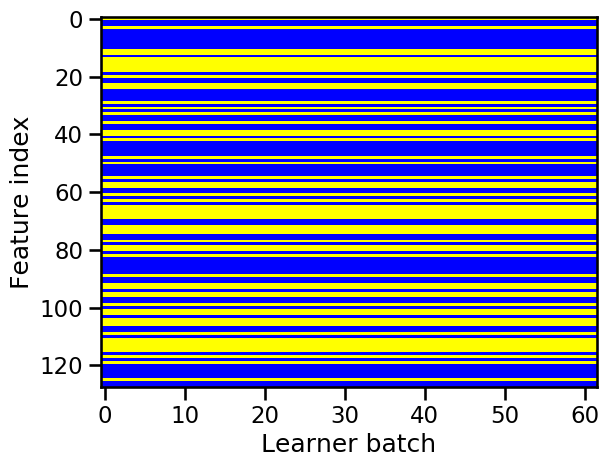

In [31]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 2, 
                                                    sharey = True,
                                                    figsize = (8, 8))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(mean_second_peaks[i] )

    fig_feat_activity.tight_layout()

plt.show()

In [32]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(len(exp_data_all)):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    
    
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)
    
    # print(num_rewards, reward_rate, window_time_stamps)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)

In [25]:
print(reward_rate_all.shape)

(1, 16)


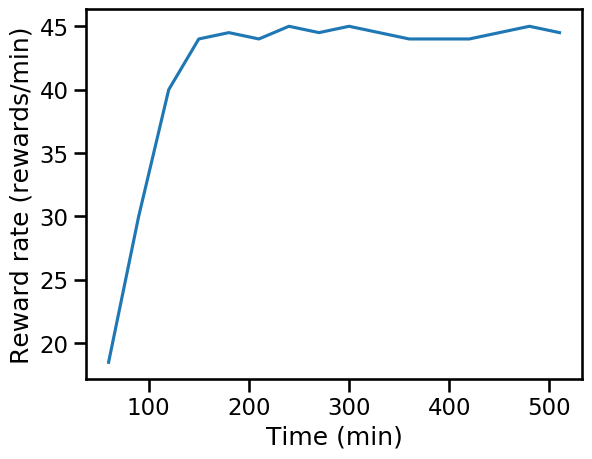

In [33]:
colors = ['blue', 'orange', 'red']

plt.plot( window_time_stamps, reward_rate_all.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')
plt.show()